In [1]:
!pip install kmodes

# New Section

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.manifold import TSNE
import umap
import xgboost as xgb
import shap

In [3]:
data = pd.read_excel('Rate_Cards_20.22.24.V2.xlsx')

In [4]:
data

,Supplier,Roles,Experience,Currency,Country,Year,Rate_Card,Delta PPI,Delta GDP,Delta Electricity,Delta Labor,Inflation
0,Supplier 1,Developer,Junior,USD,China,2020,33.112903,-0.021,790,0.036,12700,0.0530
1,Supplier 1,Developer,Senior,USD,China,2020,38.079838,-0.021,790,0.036,12700,0.0530
2,Supplier 1,Developer,Expert,USD,China,2020,49.669354,-0.021,790,0.036,12700,0.0530
3,Supplier 1,Front-end Developer,Junior,USD,China,2020,38.769690,-0.021,790,0.036,12700,0.0530
4,Supplier 1,Front-end Developer,Senior,USD,China,2020,45.806182,-0.021,790,0.036,12700,0.0530
...,...,...,...,...,...,...,...,...,...,...,...,...
4450,Supplier 11,Product Lead Engineer,Senior,USD,China,2024,50.680819,-0.070,425,0.048,8000,0.0043
4451,Supplier 11,Product Lead Engineer,Expert,USD,China,2024,57.262517,-0.070,425,0.048,8000,0.0043
4452,Supplier 11,Project Manager\nChange Management/ Training Lead,Junior,USD,China,2024,41.445534,-0.070,425,0.048,8000,0.0043
4453,Supplier 11,Project Manager\nChange Management/ Training Lead,Senior,USD,China,2024,43.643025,-0.070,425,0.048,8000,0.0043


In [5]:
# Define features and target
feature_cols = ['Supplier', 'Roles', 'Experience', 'Year',
                'Delta PPI', 'Delta GDP', 'Delta Electricity', 'Delta Labor', 'Inflation']
target_col = 'Rate_Card'

# Drop rows with missing target values
data = data.dropna(subset=[target_col])

In [ ]:
### Step 1. Clustering Analysis

In [6]:
clust_cat_features = ['Supplier', 'Roles', 'Experience']
clust_num_features = ['Year', 'Delta PPI', 'Delta GDP', 'Delta Electricity', 'Delta Labor', 'Inflation']

clust_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), clust_num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), clust_cat_features)
])

X_clust = data[feature_cols]
X_clust_processed = clust_preprocessor.fit_transform(X_clust)

In [7]:
# Evaluate clustering performance using the Elbow method and Silhouette score.
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # silhouette score requires at least 2 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42) #Not a machine learning model, unsupervised clasification system.
    cluster_labels = km.fit_predict(X_clust_processed)
    inertia.append(km.inertia_)
    sil_score = silhouette_score(X_clust_processed, cluster_labels)
    silhouette_scores.append(sil_score)
    print(f"For k = {k}: Inertia = {km.inertia_:.2f}, Silhouette Score = {sil_score:.3f}")

For k = 2: Inertia = 12604.11, Silhouette Score = 0.433
For k = 3: Inertia = 6089.60, Silhouette Score = 0.515
For k = 4: Inertia = 5680.15, Silhouette Score = 0.312
For k = 5: Inertia = 5424.86, Silhouette Score = 0.188
For k = 6: Inertia = 5332.60, Silhouette Score = 0.177
For k = 7: Inertia = 5236.64, Silhouette Score = 0.183
For k = 8: Inertia = 5006.99, Silhouette Score = 0.110
For k = 9: Inertia = 4933.32, Silhouette Score = 0.111
For k = 10: Inertia = 4860.60, Silhouette Score = 0.114


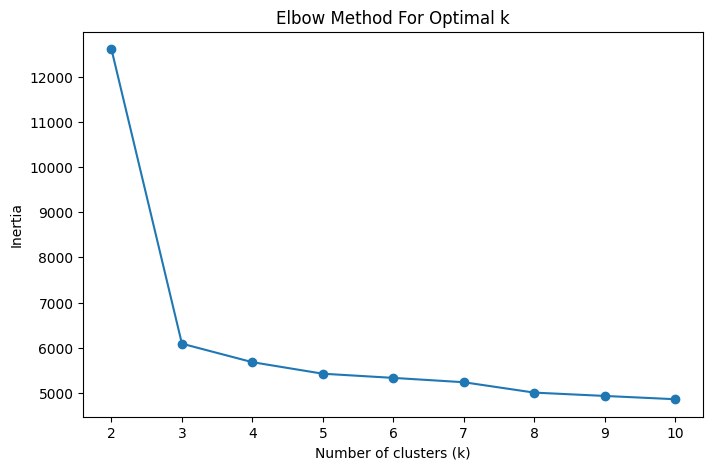

In [8]:
# Plot the elbow curve for inertia
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

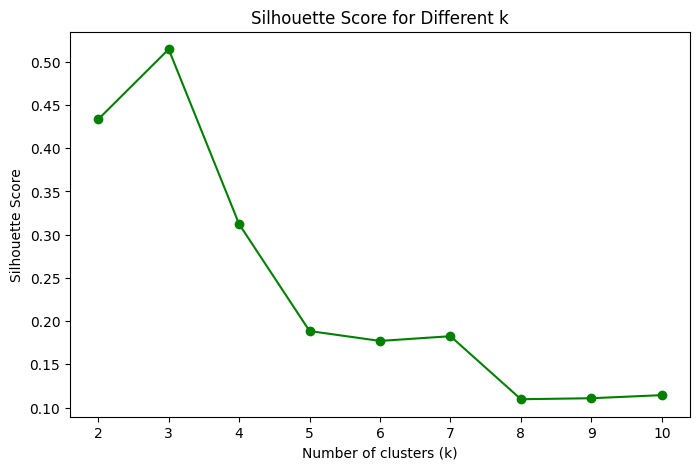

In [9]:
# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

In [10]:
# Choose an optimal number of clusters based on these metrics (example: k=3) #TRY TO SELECT THE OPTIMALA NUMBER OF CLUSTERS AUTOMATICALLY, NAME THE CLUSTERS AND ADD CLUSTER DESCRIPTION
optimal_k = 3
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans_model.fit_predict(X_clust_processed)
print("Cluster distribution:")
print(data['Cluster'].value_counts())

Cluster distribution:
Cluster
0    1475
1     920
2     365
Name: count, dtype: int64


<ipython-input-10-d0106a72a158>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans_model.fit_predict(X_clust_processed)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


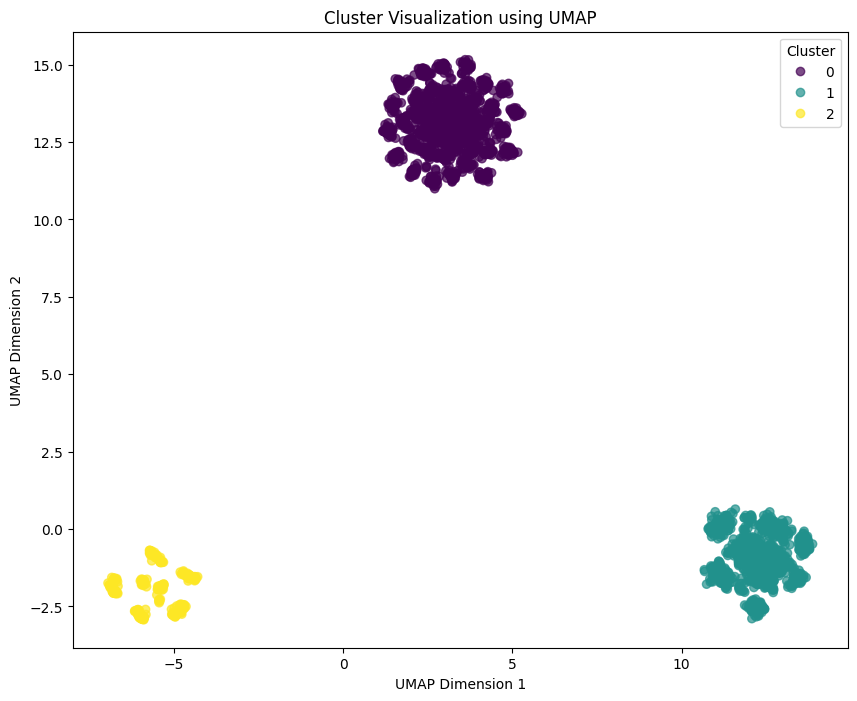

In [11]:
# Create a UMAP model to reduce the preprocessed clustering data to 2 dimensions.
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_clust_processed)

# Plot the UMAP results, coloring points by the assigned cluster.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Cluster Visualization using UMAP")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

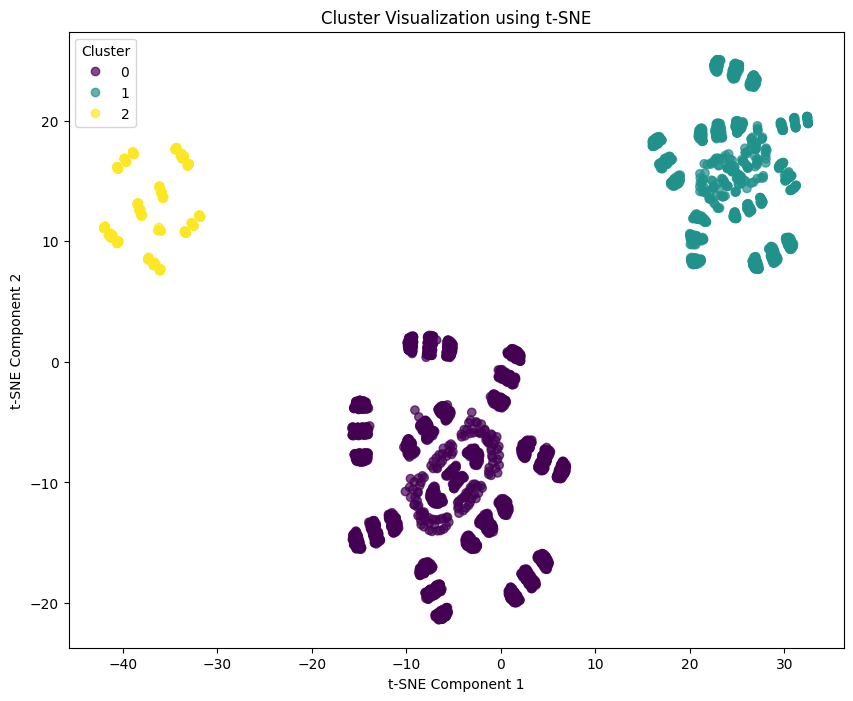

In [12]:
# Use t-SNE to reduce the dimensionality to 2 components, set init="random" to avoid the sparse issue.
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="random")
X_tsne = tsne.fit_transform(X_clust_processed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Cluster Visualization using t-SNE')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [ ]:
### Step 2. Build the Predictive Model Including the Cluster

In [13]:
# Create a new feature set that includes the cluster label.
X_supervised = data[feature_cols].copy()
X_supervised['Cluster'] = data['Cluster']
y = data[target_col]

In [14]:
# For supervised learning, the categorical features remain the same.
sup_cat_features = ['Supplier', 'Roles', 'Experience','Cluster']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #Impute missing by using the most frequent value along each column
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) #Encode as one-hot

sup_num_features = ['Year', 'Delta PPI', 'Delta GDP', 'Delta Electricity', 'Delta Labor', 'Inflation']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()), #Impute missing values by setting those to the mean value along each column
    ('standardscaler', StandardScaler())
      ]) #Standardize numerical features by removing the mean and scaling to unit variance

In [ ]:
#Create rail switch to correctly route each column to the correct pipel
#sup_preprocessor = make_column_transformer(
#    (cat_pipe, sup_cat_features ),
#    (num_pipe, sup_num_features), verbose_feature_names_out=False).set_output(transform="pandas")

In [15]:
# Create a preprocessor for the supervised model.
sup_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), sup_num_features),
    ('cat', OneHotEncoder(drop='first'), sup_cat_features)
])

In [16]:
# Split historical data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y, test_size=0.2, random_state=42)

In [17]:
# Build a pipeline that preprocesses the data then fits an XGBoost Regressor.
model_pipeline = Pipeline(steps=[
    ('preprocessor', sup_preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))
])

In [18]:
# Train the predictive model.
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Delta PPI',
                                                   'Delta GDP',
                                                   'Delta Electricity',
                                                   'Delta Labor',
                                                   'Inflation']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Supplier', 'Roles',
                                                   'Experience',
                                                   'Cluster'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [19]:
# Evaluate using cross-validation (R^2, MAE, and MAPE)
cv_r2_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='r2')
cv_mae_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_mae_scores  # Negate because scores are negative

# MAPE: use the built-in scorer. Note that 'neg_mean_absolute_percentage_error' returns a fraction,
# so we multiply by 100 to get percentage values.
cv_mape_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
cv_mape_scores = -cv_mape_scores * 100

print("Cross-validated R^2 scores:", cv_r2_scores)
print("Mean R^2:", np.mean(cv_r2_scores))
print("Cross-validated MAE scores:", cv_mae_scores)
print("Mean MAE:", np.mean(cv_mae_scores))
print("Cross-validated MAPE scores (%):", cv_mape_scores)
print("Mean MAPE (%):", np.mean(cv_mape_scores))

Cross-validated R^2 scores: [0.95564937 0.9544812  0.93447748 0.95143048 0.96148625]
Mean R^2: 0.9515049574648569
Cross-validated MAE scores: [9.35731884 7.76161674 7.61642391 8.19729731 7.54396625]
Mean MAE: 8.095324609319714
Cross-validated MAPE scores (%): [11.90215189 10.33135027 10.69559756 10.65241508 10.6486481 ]
Mean MAPE (%): 10.846032582072503


In [20]:
# Evaluate on the test set.
test_r2_score = model_pipeline.score(X_test, y_test)
y_test_pred = model_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("Test R^2 score:", test_r2_score)
print("Test MAE:", test_mae)
print("Test MAPE (%):", test_mape)

Test R^2 score: 0.9576368063336004
Test MAE: 6.8797118781673285
Test MAPE (%): 9.476757903138267


In [21]:
# -------------------------
# Export the dataset with the cluster label added as a new column.
export_filename = "data_with_clusters.csv"
data.to_csv(export_filename, index=False)
print(f"Dataset with cluster labels exported as '{export_filename}'.")

Dataset with cluster labels exported as 'data_with_clusters.csv'.


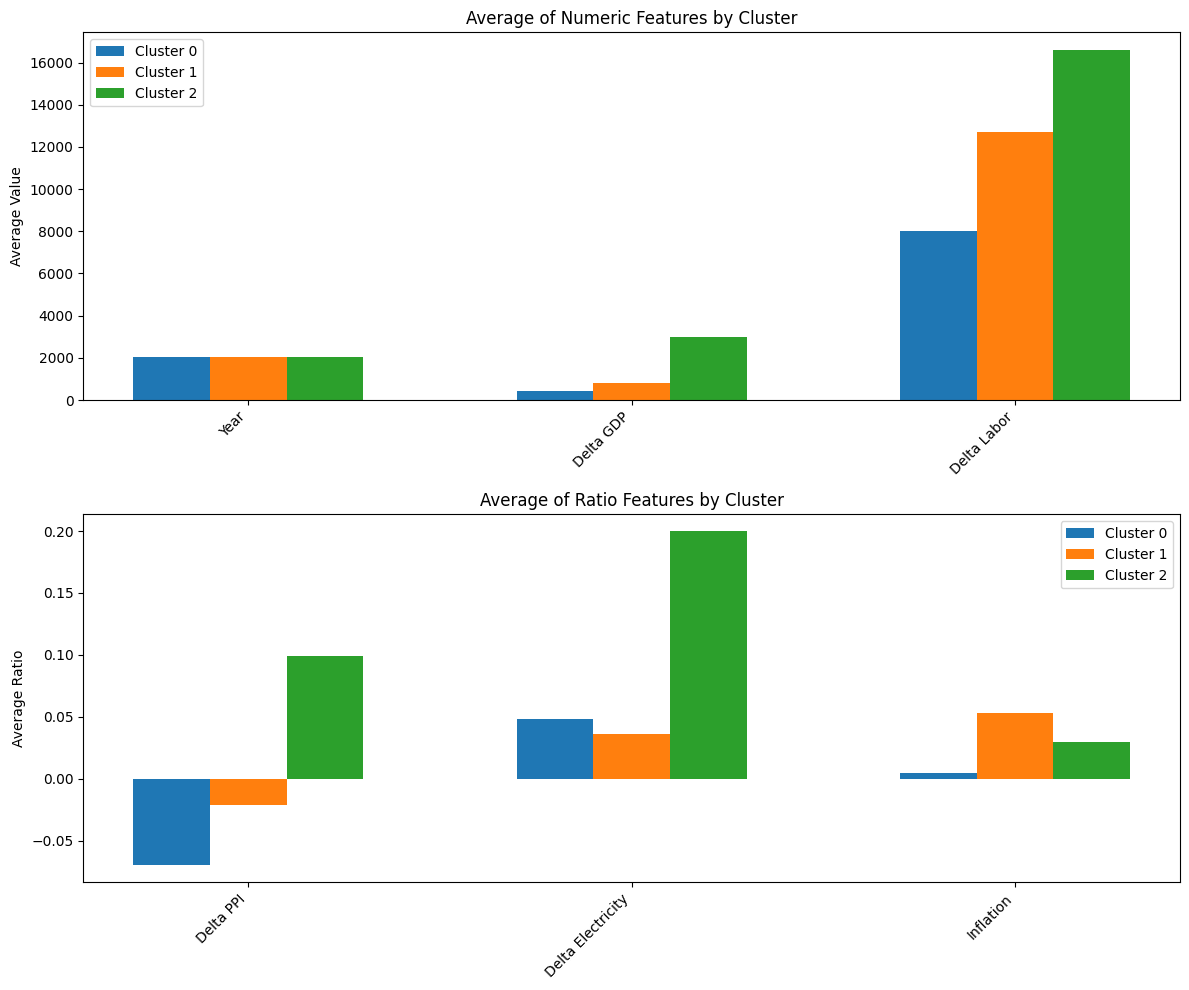

In [22]:
import numpy as np #MATCH THE COLOR CLUSTERS TO THE PREDICTEDS VS. ACTUALS (INCLUDE UNIT LABEKL IN THE GRAPHS)
import matplotlib.pyplot as plt

# Define feature groups.
num_features = ['Year', 'Delta GDP', 'Delta Labor']
ratio_features = ['Delta PPI', 'Delta Electricity', 'Inflation']

# Compute the average of each feature for every cluster.
group_means_numbers = data.groupby('Cluster')[num_features].mean()
group_means_ratios = data.groupby('Cluster')[ratio_features].mean()

# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Numeric features
x1 = np.arange(len(num_features))
width = 0.2
n_clusters = group_means_numbers.shape[0]
for i, cluster in enumerate(group_means_numbers.index):
    ax1.bar(x1 + i * width, group_means_numbers.loc[cluster].values, width, label=f'Cluster {cluster}')
ax1.set_xticks(x1 + width * (n_clusters - 1) / 2)
ax1.set_xticklabels(num_features, rotation=45, ha='right')
ax1.set_ylabel("Average Value")
ax1.set_title("Average of Numeric Features by Cluster")
ax1.legend()

# Subplot 2: Ratio features
x2 = np.arange(len(ratio_features))
n_clusters = group_means_ratios.shape[0]
for i, cluster in enumerate(group_means_ratios.index):
    ax2.bar(x2 + i * width, group_means_ratios.loc[cluster].values, width, label=f'Cluster {cluster}')
ax2.set_xticks(x2 + width * (n_clusters - 1) / 2)
ax2.set_xticklabels(ratio_features, rotation=45, ha='right')
ax2.set_ylabel("Average Ratio")
ax2.set_title("Average of Ratio Features by Cluster")
ax2.legend()

plt.tight_layout()
plt.show()


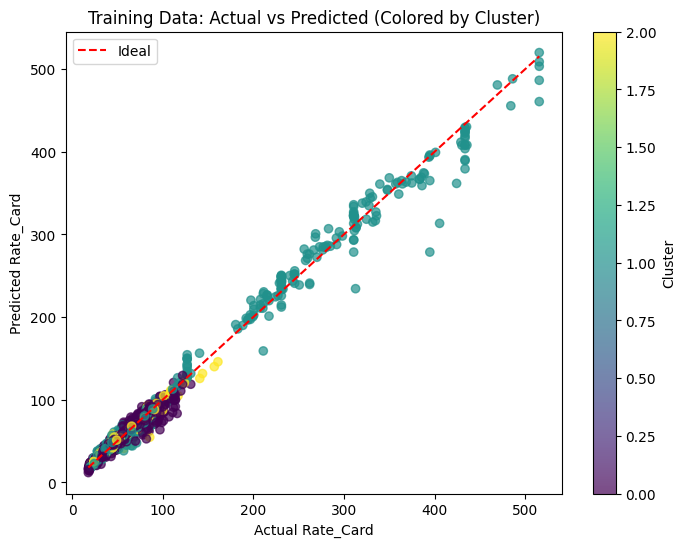

In [23]:
# Plot Predicted vs Actual for Training Data with Cluster Colors
y_train_pred = model_pipeline.predict(X_train)
plt.figure(figsize=(8, 6))
sc_train = plt.scatter(y_train, y_train_pred, c=X_train['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("Actual Rate_Card")
plt.ylabel("Predicted Rate_Card")
plt.title("Training Data: Actual vs Predicted (Colored by Cluster)")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label="Ideal")
cbar = plt.colorbar(sc_train)
cbar.set_label("Cluster")
plt.legend()
plt.show()

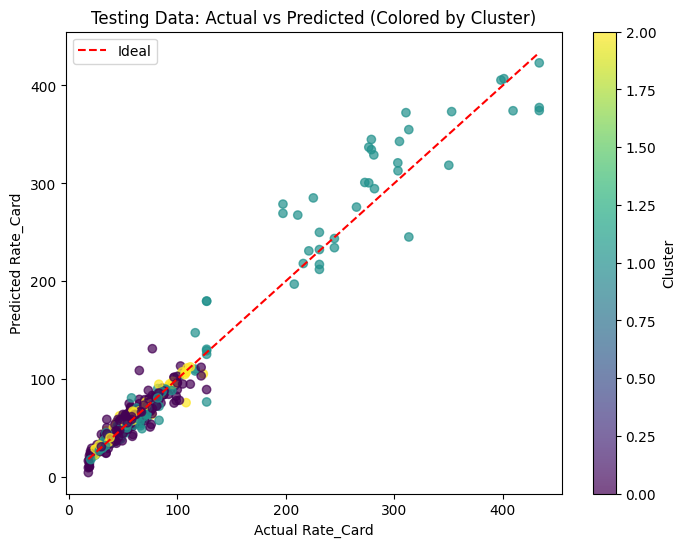

In [24]:
# Plot Predicted vs Actual for Testing Data with Cluster Colors
y_test_pred = model_pipeline.predict(X_test)
plt.figure(figsize=(8, 6))
sc_test = plt.scatter(y_test, y_test_pred, c=X_test['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("Actual Rate_Card")
plt.ylabel("Predicted Rate_Card")
plt.title("Testing Data: Actual vs Predicted (Colored by Cluster)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal")
cbar = plt.colorbar(sc_test)
cbar.set_label("Cluster")
plt.legend()
plt.show()

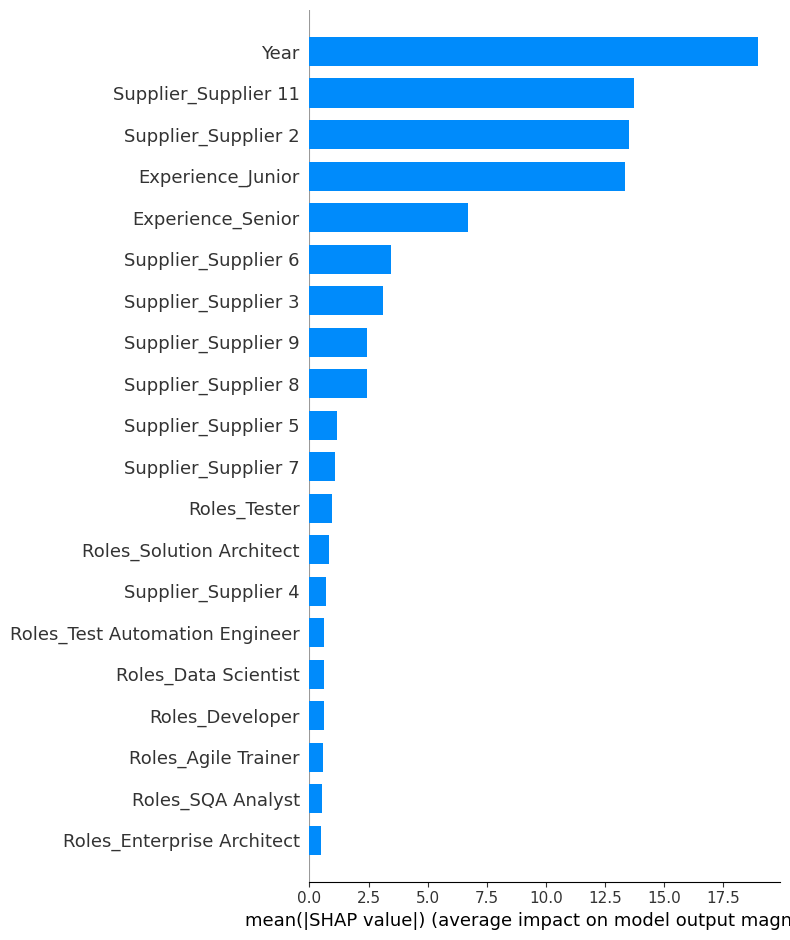

In [39]:
# Step 2.5. SHAP Analysis for Model Explanation
X_train_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)

# Retrieve feature names after preprocessing.
num_features = sup_num_features  # Numeric features remain the same.
cat_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(sup_cat_features)
feature_names = np.concatenate([num_features, cat_features])

# Create a SHAP TreeExplainer on the trained XGBoost model.
explainer = shap.TreeExplainer(model_pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_train_transformed)
shap.initjs()

# Plot a summary plot of feature importance using SHAP values.
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

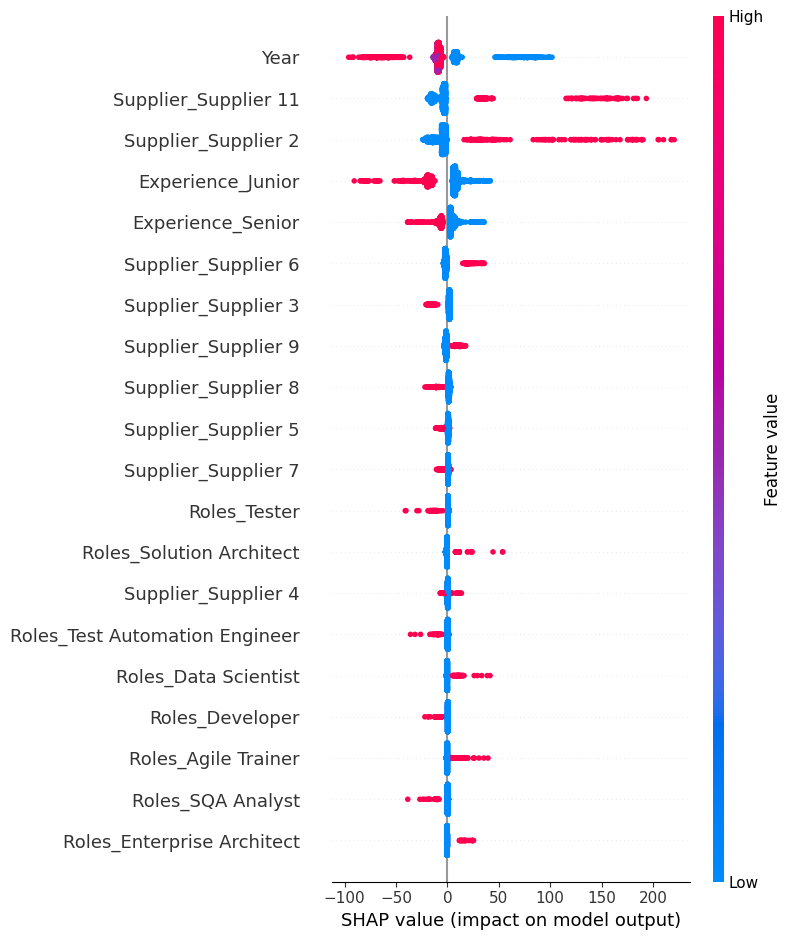

In [40]:
X_train_dense = X_train_transformed.toarray()

X_shap_df = pd.DataFrame(X_train_dense, columns=feature_names)

shap.summary_plot(shap_values, X_shap_df, plot_type="dot")

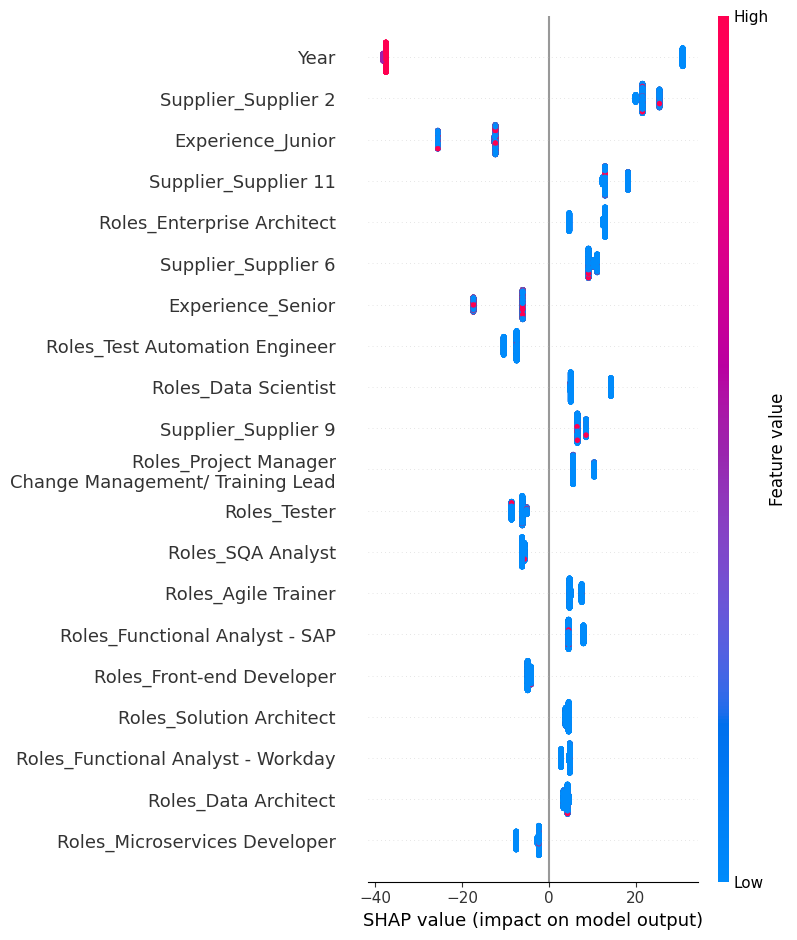

In [26]:
# If the transformed training data is sparse, convert to dense:
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# Now compute SHAP values using the dense array
explainer = shap.TreeExplainer(model_pipeline.named_steps['regressor'].get_booster())
shap_values = explainer.shap_values(X_train_transformed)

# Create the summary plot with feature names
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

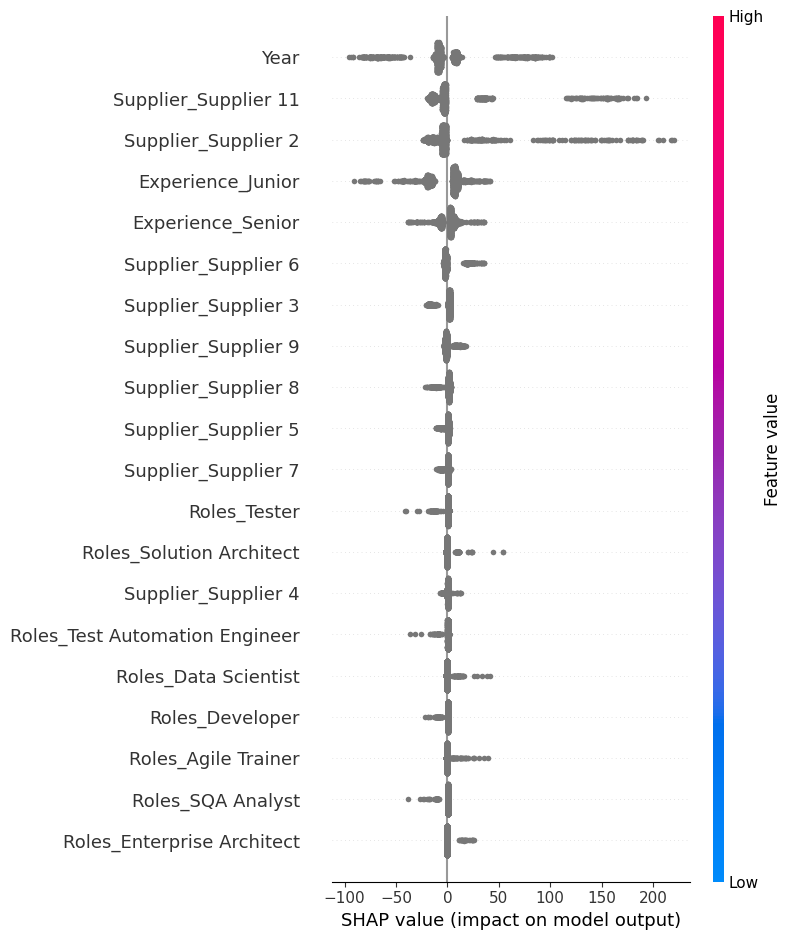

In [38]:
# Transform your training set ###TRY TO USE AN LLM TO DESCRIBE SHAP TO AN EXECUTIVE IN BUSINESS TERMS
X_train_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train)

# Now compute SHAP values using the dense array
explainer = shap.TreeExplainer(model_pipeline.named_steps['regressor'].get_booster())
shap_values = explainer.shap_values(X_train_transformed)

# Create the summary plot with feature names
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

In [ ]:
# -------------------------
# Step 3. Predicting Future Values with User Input (Revised for All Combinations)
print("\nPlease provide the future data details to predict Rate_Card:")
year = int(input("Enter Year (e.g., 2026): "))
delta_ppi = float(input("Enter Delta PPI (in %): "))
delta_gdp = float(input("Enter Delta GDP (in billion USD): "))
delta_electricity = float(input("Enter Delta Electricity (in %): "))
delta_labor = float(input("Enter Delta Labor (in USD): "))
inflation = float(input("Enter Inflation (in %): "))

# Retrieve unique options for the categorical features.
valid_suppliers = data['Supplier'].unique()
valid_roles = data['Roles'].unique()
valid_experiences = data['Experience'].unique()

# Create all combinations of Supplier, Roles, and Experience.
import itertools
cat_combinations = list(itertools.product(valid_suppliers, valid_roles, valid_experiences))
future_data = pd.DataFrame(cat_combinations, columns=['Supplier', 'Roles', 'Experience'])

# Add the numeric inputs to all rows.
future_data['Year'] = year
future_data['Delta PPI'] = delta_ppi
future_data['Delta GDP'] = delta_gdp
future_data['Delta Electricity'] = delta_electricity
future_data['Delta Labor'] = delta_labor
future_data['Inflation'] = inflation

# Ensure the column order matches the feature_cols definition.
future_data = future_data[['Supplier', 'Roles', 'Experience', 'Year',
                           'Delta PPI', 'Delta GDP', 'Delta Electricity', 'Delta Labor', 'Inflation']]



Please provide the future data details to predict Rate_Card:
Enter Year (e.g., 2026): 2025
Enter Delta PPI (in %): .12
Enter Delta GDP (in billion USD): 750
Enter Delta Electricity (in %): -.05
Enter Delta Labor (in USD): 12000
Enter Inflation (in %): .06


In [ ]:
# Use the clustering preprocessor and kmeans model to assign a cluster to each new data point. #LOOK INTO THE CLUSTERS FOR THE PREDICTIONS AND SHOW PERFORMANCE METRICS
future_processed = clust_preprocessor.transform(future_data)
future_cluster = kmeans_model.predict(future_processed)
future_data['Cluster'] = future_cluster

# Use the predictive model pipeline to forecast Rate_Card for each combination.
predicted_rate = model_pipeline.predict(future_data)
future_data['Predicted Rate_Card'] = predicted_rate #ROUND IT TO TWO DECIMAL PLACES

# Export the table of predictions as a CSV file.
output_filename = "predictions.csv"
future_data.to_csv(output_filename, index=False)
print(f"\nPrediction table has been exported as '{output_filename}'.")


Prediction table has been exported as 'predictions.csv'.
